# <span style="color:#343434" id="section_1">1. Exploration</span>






# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import tensorflow as tf
from tensorflow import keras
import timeit

from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import exposure, transform
import matplotlib.image as mpimg
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import imageio.v3 as iio
import ipympl

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib widget

import warnings
warnings.filterwarnings('ignore')

In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


# <span style="color:#343434" id="section_1">1. Exploration & preprocessing</span>

## <span style="color:#343434" id="section_1_1">1.1. Visualisation de la liste des races *(classes)* et un exemple de données.</span>

In [3]:
# Define path to data
annotations_dir = 'C:/Users/A475388/Repo_Github/OC_IML_P6/data/Annotation' 
images_dir = 'C:/Users/A475388/Repo_Github/OC_IML_P6/data/Images'

In [4]:
# Count the number of classes (dogs breeds)
breed_list = os.listdir(images_dir)
print(f"{len(breed_list)} races sont présentes dans le dossier")

120 races sont présentes dans le dossier


Nous somes sur un contexte mutliclasses comportant 120 classes (races) différentes. <br/>
Nous n'avons pas de GPU, nous nous limiterons donc à 5 classes pour construire le modèle.

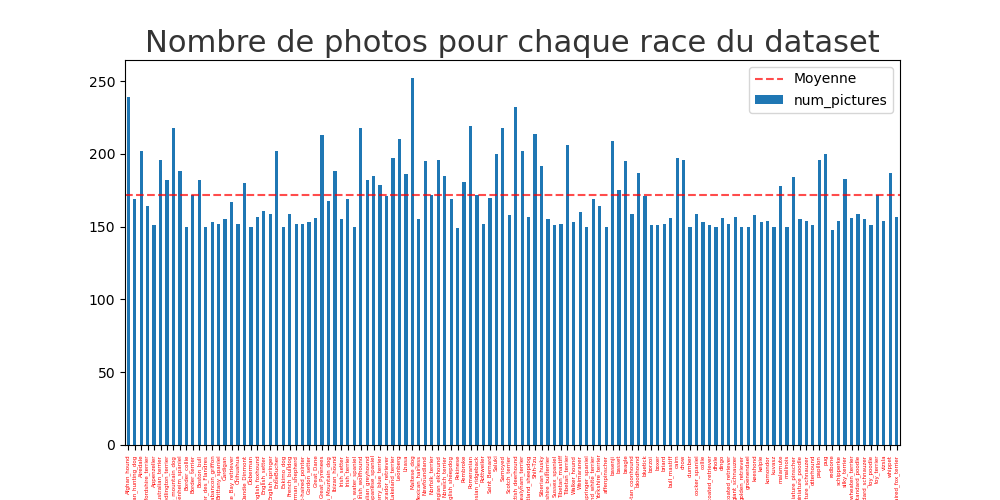

In [5]:
# Count number of pictures for each breed
df_breeds = pd.DataFrame(
    index=[breed.split('-',1)[1]
           for breed in breed_list],
    data=[len(os.listdir(images_dir + "/" + name))
          for name in breed_list],
    columns=["num_pictures"])
df_breeds = df_breeds.reset_index()
df_breeds = df_breeds.sort_values(by = 'index', ascending = True)

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(10,5))
df_breeds.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(),
           color='r', alpha=.7,
           linestyle='--',
           label="Moyenne")
plt.title("Nombre de photos pour chaque "\
          "race du dataset",
          color="#343434", fontsize=22)

ax.xaxis.set_ticklabels(df_breeds["index"], 
                        rotation = 90, 
                        color = 'red', 
                        fontsize = 4, 
                        #style = 'italic', 
                        #verticalalignment = 'center'
                       )

plt.legend()
plt.show()

Nous conserverons les 5 races les plus "fournies" en photos : 

In [6]:
df_breeds.sort_values(by = 'num_pictures', ascending = False).head(5)

index  num_pictures
2           Maltese_dog           252
9          Afghan_hound           239
26   Scottish_deerhound           232
107          Pomeranian           219
106             Samoyed           218

In [7]:
df_breeds.sort_values(by = 'index', ascending = True)['index'].to_list()

['Afghan_hound',
 'African_hunting_dog',
 'Airedale',
 'American_Staffordshire_terrier',
 'Appenzeller',
 'Australian_terrier',
 'Bedlington_terrier',
 'Bernese_mountain_dog',
 'Blenheim_spaniel',
 'Border_collie',
 'Border_terrier',
 'Boston_bull',
 'Bouvier_des_Flandres',
 'Brabancon_griffon',
 'Brittany_spaniel',
 'Cardigan',
 'Chesapeake_Bay_retriever',
 'Chihuahua',
 'Dandie_Dinmont',
 'Doberman',
 'English_foxhound',
 'English_setter',
 'English_springer',
 'EntleBucher',
 'Eskimo_dog',
 'French_bulldog',
 'German_shepherd',
 'German_short-haired_pointer',
 'Gordon_setter',
 'Great_Dane',
 'Great_Pyrenees',
 'Greater_Swiss_Mountain_dog',
 'Ibizan_hound',
 'Irish_setter',
 'Irish_terrier',
 'Irish_water_spaniel',
 'Irish_wolfhound',
 'Italian_greyhound',
 'Japanese_spaniel',
 'Kerry_blue_terrier',
 'Labrador_retriever',
 'Lakeland_terrier',
 'Leonberg',
 'Lhasa',
 'Maltese_dog',
 'Mexican_hairless',
 'Newfoundland',
 'Norfolk_terrier',
 'Norwegian_elkhound',
 'Norwich_terrier',
 '

In [8]:
df_breeds[df_breeds['index'].eq('French_bulldog')]

index  num_pictures
94  French_bulldog           159

In [9]:
def show_images_classes(path, classes, num_sample):
    """This function is used to display the first 
    n images of a directory passed as an argument. 
    It is adapted to subdirectories. 
    
    The matplotlib.image library must be loaded 
    with the alias mpimg. 

    Parameters
    ----------------------------------------
    path : string
        Link of root directory
    classes : string 
        Name of the subdirectory
    num_smaple : integer
        Number of picture to show
    ----------------------------------------
    """
    fig = plt.figure(figsize=(8,8))
    fig.patch.set_facecolor('#343434')
    plt.suptitle("{}".format(classes.split("-")[1]), y=.83,
                 color="white", fontsize=22)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path+"/"+classes+"/"+images[i])
        plt.subplot(num_sample+1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

In [10]:
list_races = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 
              'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02108915-French_bulldog']

n02085936-Maltese_dog


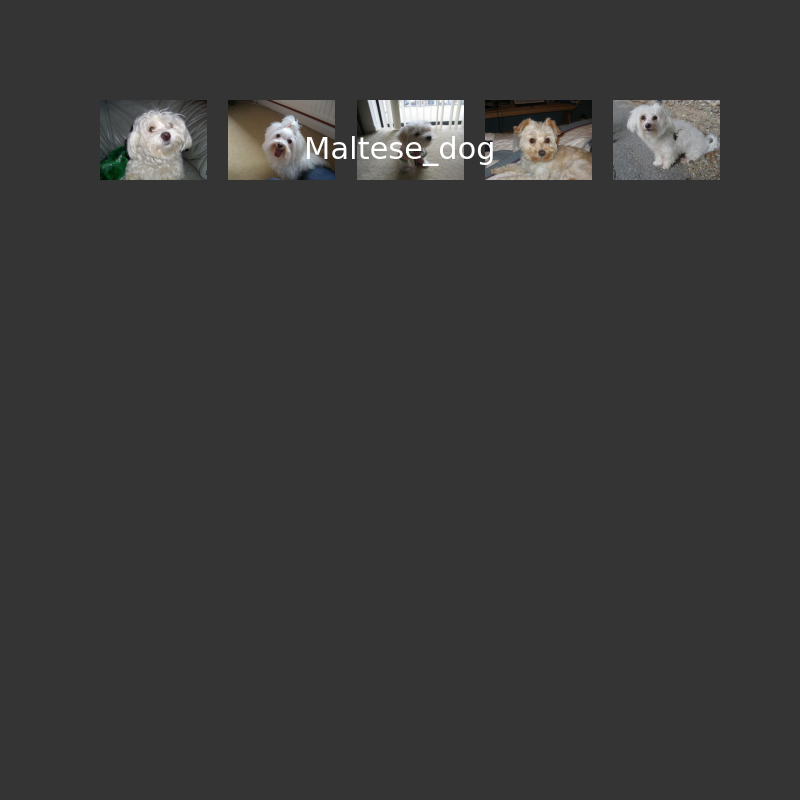

n02088094-Afghan_hound


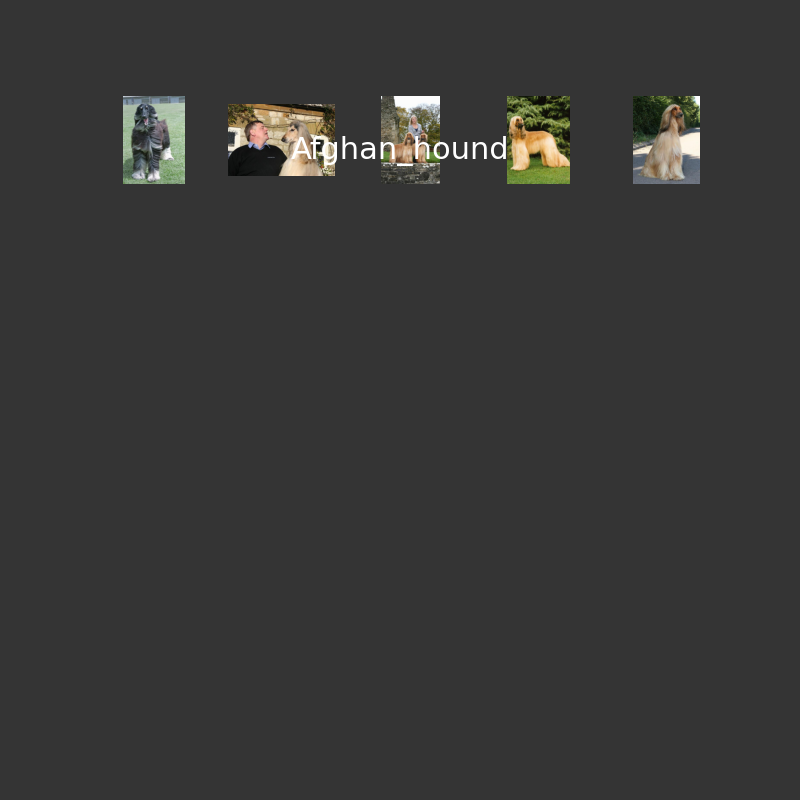

n02092002-Scottish_deerhound


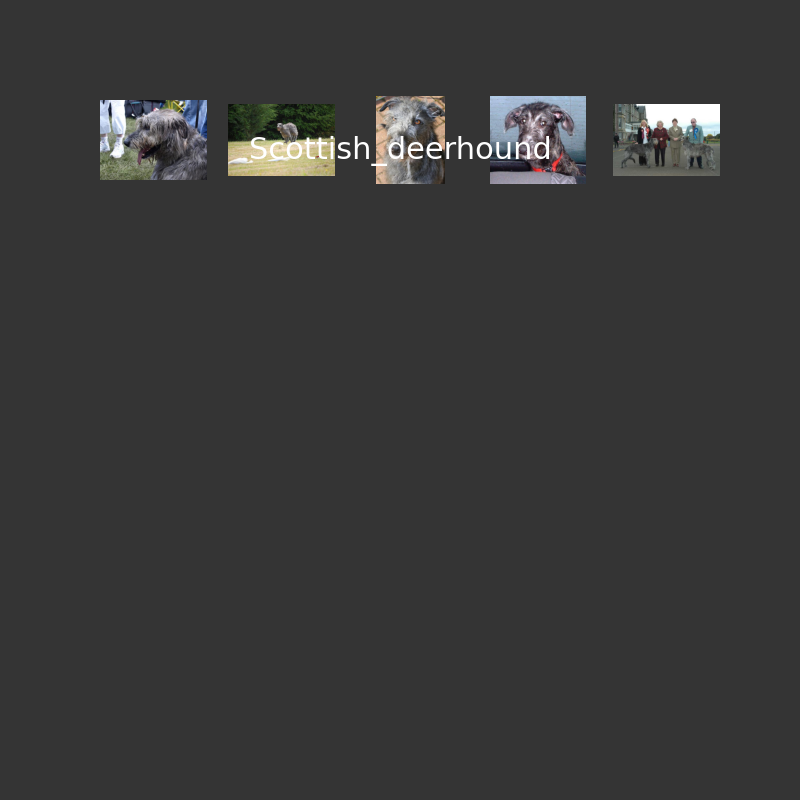

n02112018-Pomeranian


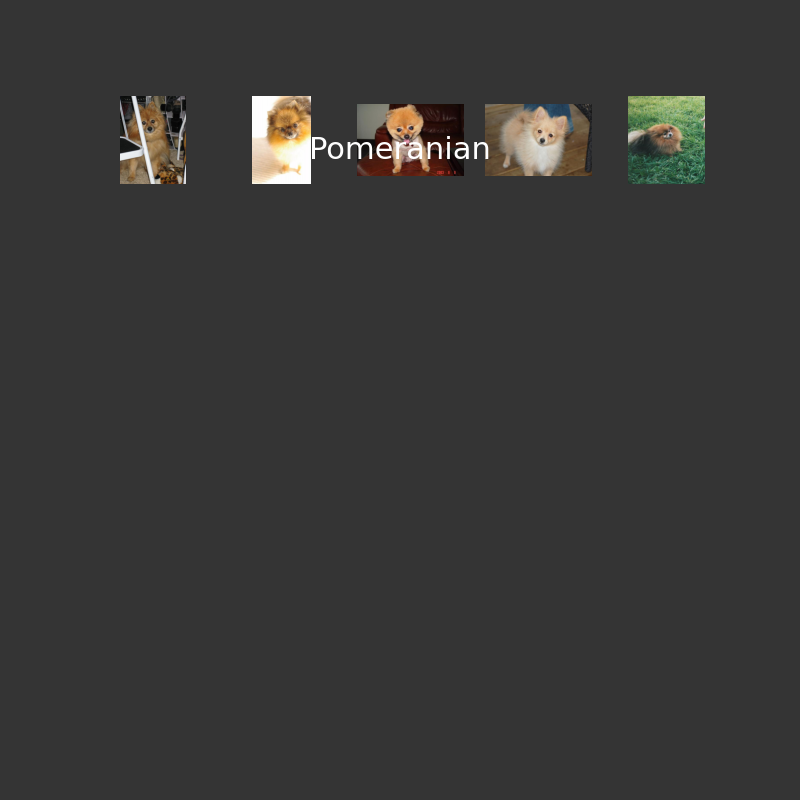

n02108915-French_bulldog


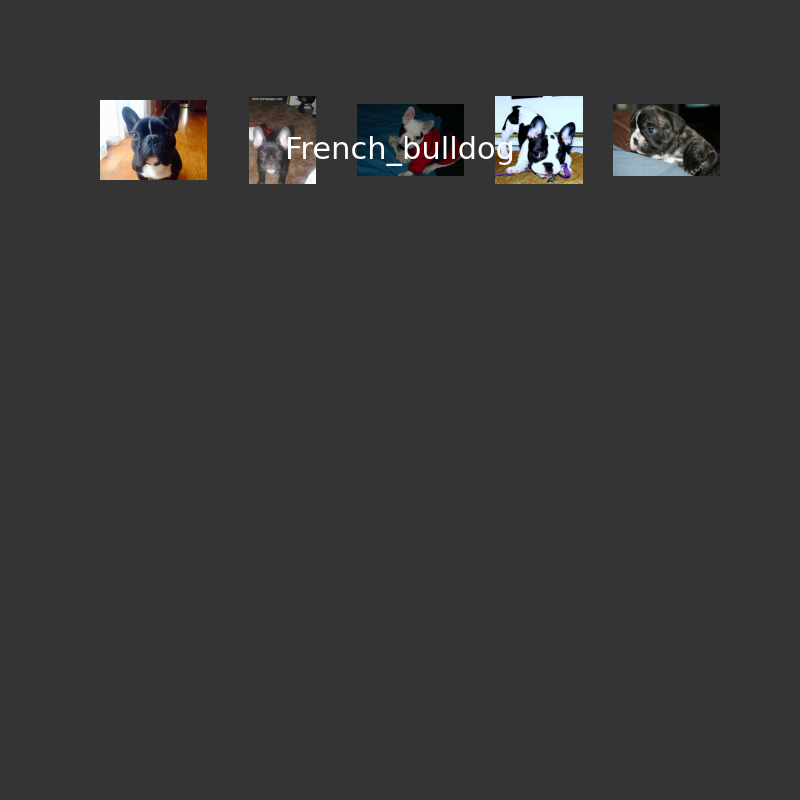

In [11]:
for i in list_races:
    print(i)
    show_images_classes(images_dir, i, 5)

## <span style="color:#343434" id="section_1_2">1.2. Actions test sur les photos.</span>

### Redimensionnement

In [12]:
# Define test image
img_test = (images_dir 
            + "/" 
            + "n02108915-French_bulldog/n02108915_57.jpg")
img_test = cv.imread(img_test)

In [13]:
print(f"Largeur : {img_test.shape[0]} px, hauteur : {img_test.shape[1]} px")

Largeur : 375 px, hauteur : 500 px


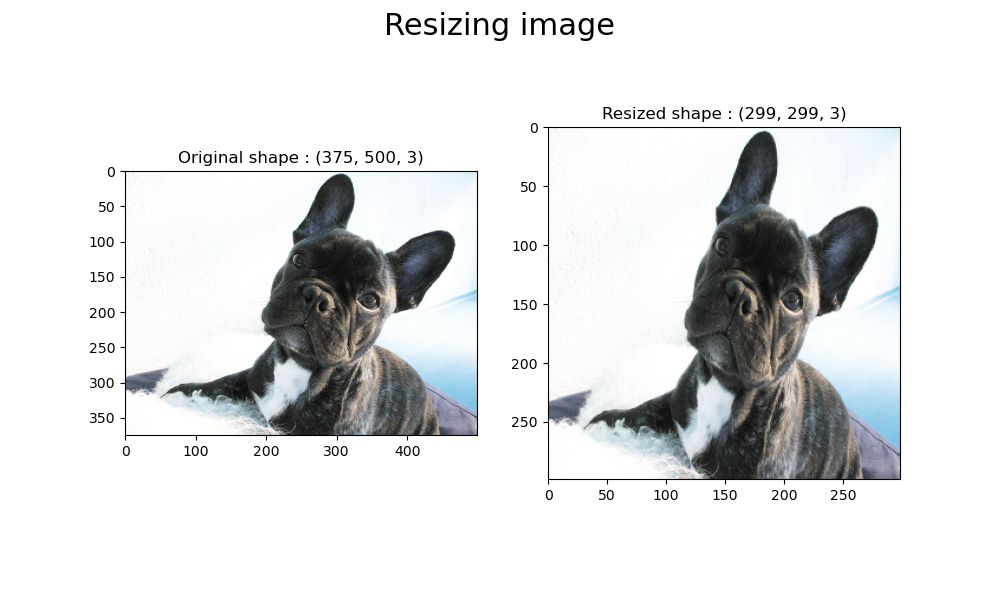

In [14]:
# setting dim of the resize
height = 299
width = 299
dim = (width, height)
# resize image with OpenCV
res_img = cv.resize(img_test, dim, interpolation=cv.INTER_LINEAR)

# Show both img
fig = plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Original shape : {}".format(img_test.shape))
plt.subplot(1, 2, 2)
plt.imshow(res_img)
plt.title("Resized shape : {}".format(res_img.shape))
plt.suptitle("Resizing image",
             color="black", 
             fontsize=22, y=.98)
plt.show()

### Modification de l'histogramme des images

In [15]:
# Transform image with differents color sets
img_RGB = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
img_grayscale = cv.cvtColor(img_test, cv.COLOR_RGB2GRAY)
img_YUV = cv.cvtColor(img_test,cv.COLOR_BGR2YUV)

In [16]:
# Create histogram
def plot_histogram(init_img, convert_img):
    """Function allowing to display the initial
    and converted images according to a certain
    colorimetric format as well as the histogram
    of the latter. 

    Parameters
    -------------------------------------------
    init_img : list
        init_img[0] = Title of the init image
        init_img[1] = Init openCV image
    convert_img : list
        convert_img[0] = Title of the converted
        convert_img[1] = converted openCV image
    -------------------------------------------
    """
    hist, bins = np.histogram(
                    convert_img[1].flatten(),
                    256, [0,256])
    # Cumulative Distribution Function
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    # Plot histogram
    fig = plt.figure(figsize=(12,5))
    plt.subplot(1, 3, 1)
    plt.imshow(init_img[1])
    plt.title("{} Image".format(init_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 2)
    plt.imshow(convert_img[1])
    plt.title("{} Image".format(convert_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 3)
    plt.plot(cdf_normalized, 
             color='r', alpha=.7,
             linestyle='--')
    plt.hist(convert_img[1].flatten(),256,[0,256])
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title("Histogram of convert image", color="#343434")
    plt.suptitle("Histogram and cumulative "\
                 "distribution for test image",
              color="black", fontsize=22, y=.98)
    plt.show()

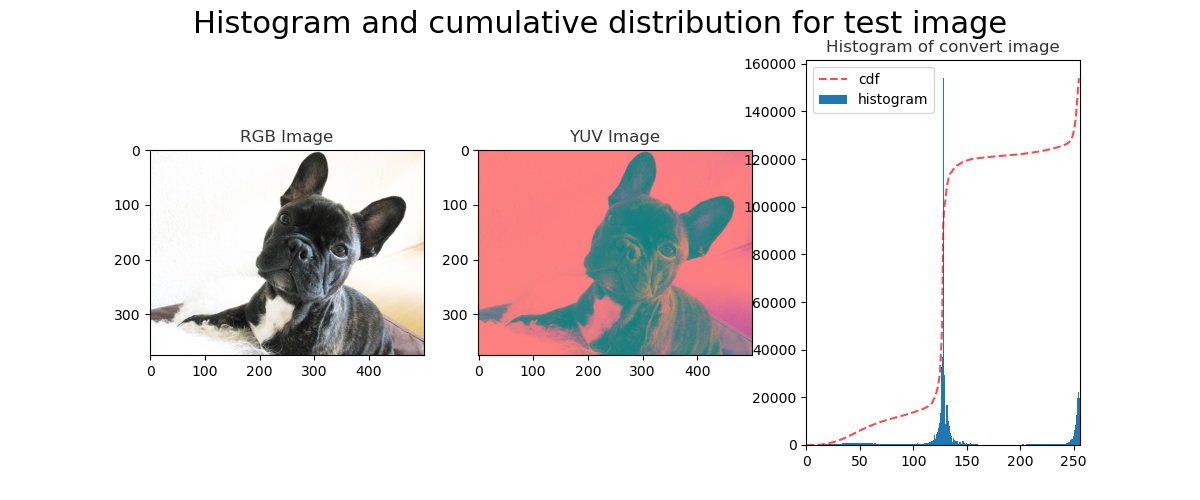

In [17]:
plot_histogram(["RGB", img_RGB], ["YUV", img_YUV])

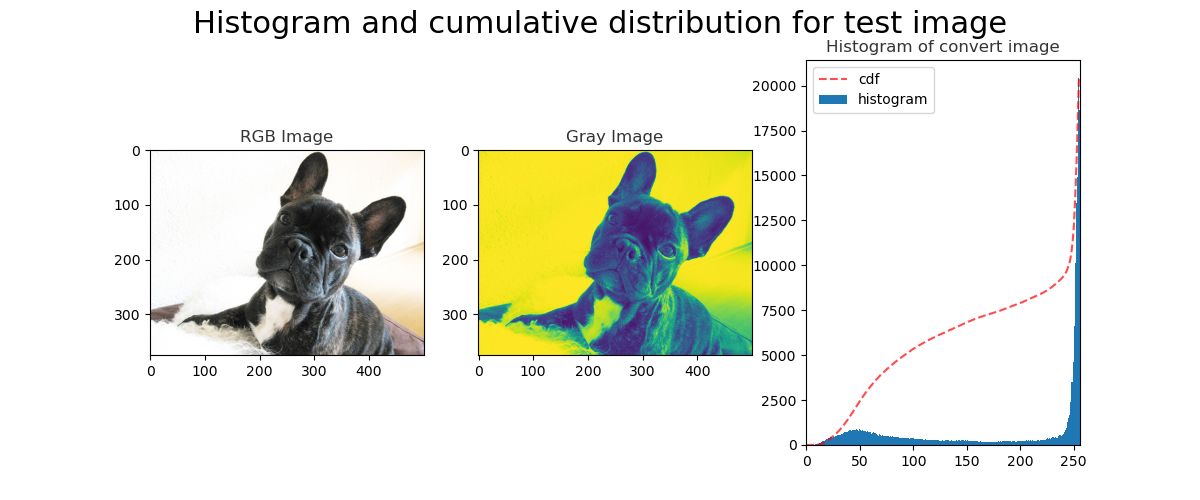

In [18]:
plot_histogram(["RGB", img_RGB], ["Gray", img_grayscale])

**Egalisation**<br/>
avec OpenCV<br/>
L'intérêt de convertir l'image dans l'espace colorimétrique YUV est de pouvoir agir sur le canal "luminance" (Y) indépendamment des autres canaux de chrominance. Nous allons donc réaliser l'égalisation sur ce seul canal Y :

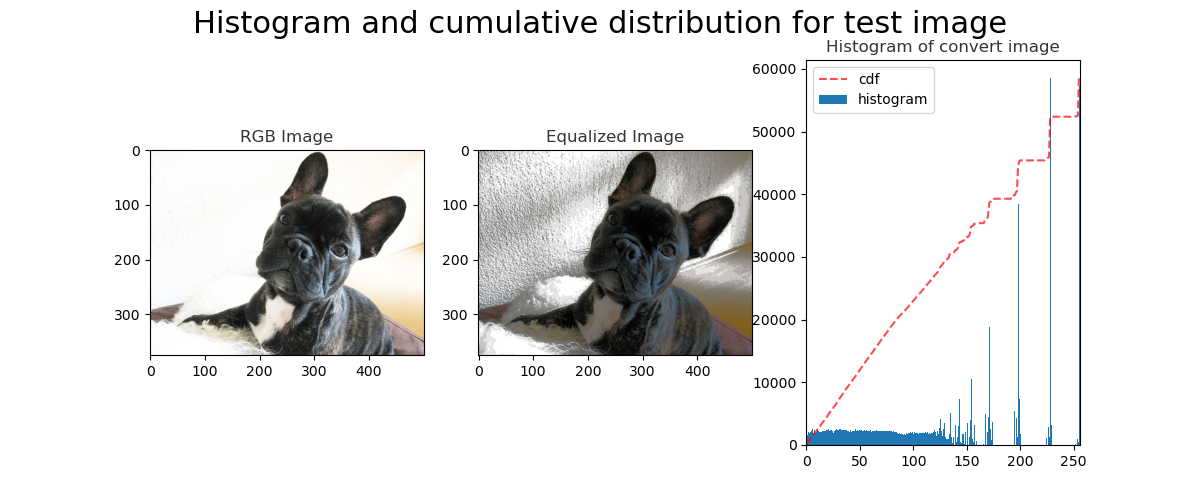

In [19]:
# Equalization
img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
plot_histogram(["RGB", img_RGB], ["Equalized", img_equ])

**Application de filtres**

Pour pallier au bruit présent dans les images, il est possible d'appliquer un filtre. Il en existe de plusieurs types : les filtres linéaires (comme le filtre Gaussien), non linéaires comme le filtre médian par exemple.      
un des meilleurs filtre pour débruiter l'image est le **filtre non-local means**.


### Filtre non-local means
Contrairement aux filtres « moyenne locale », qui prennent la valeur moyenne d'un groupe de pixels entourant un pixel cible pour lisser l'image, le filtrage des moyennes non locales prend une moyenne de **tous les pixels de l'image**, pondérée par la similarité de ces pixels avec le pixel cible. Cela se traduit par une clarté de post-filtrage beaucoup plus grande et moins de perte de détails dans l'image par rapport aux algorithmes de moyenne locale.

Testons ce fitre sur notre image test :

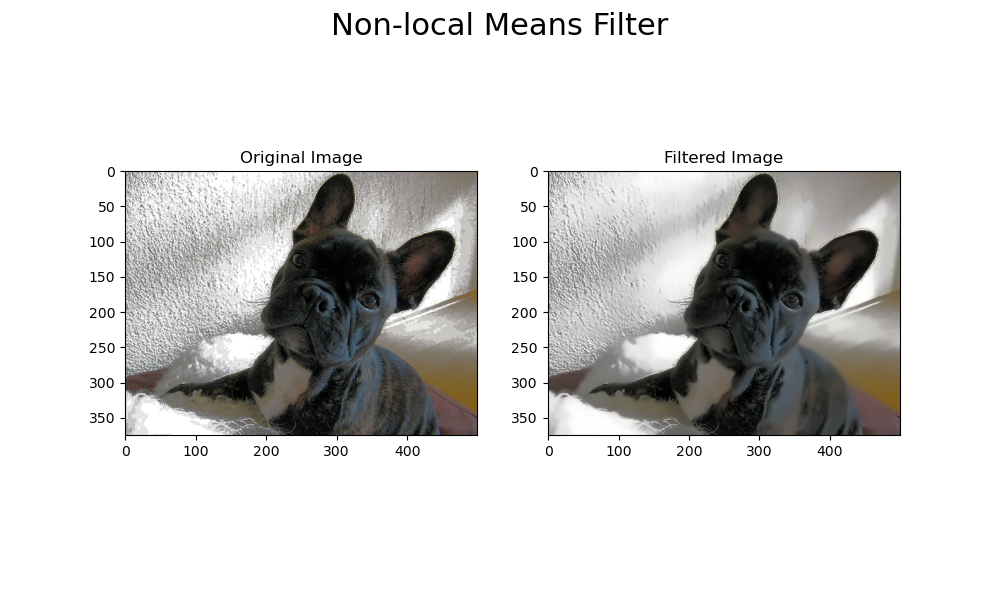

In [20]:
# Apply non-local means filter on test img
dst_img = cv.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

# Show both img
fig = plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.imshow(img_equ)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(dst_img)
plt.title("Filtered Image")
plt.suptitle("Non-local Means Filter",
             color="black", 
             fontsize=22, y=.98)
plt.show()

**Augmentation de données**<br/>
L'objectif de la data augmentation est de reproduire les images préexistantes en leur appliquant une transformation aléatoire. Pour cela, Keras mets à disposition la méthode ImageDataGenerator qui permet de faire à la fois du mirroring, de la rotation, des zoom ... de manière aléatoire.

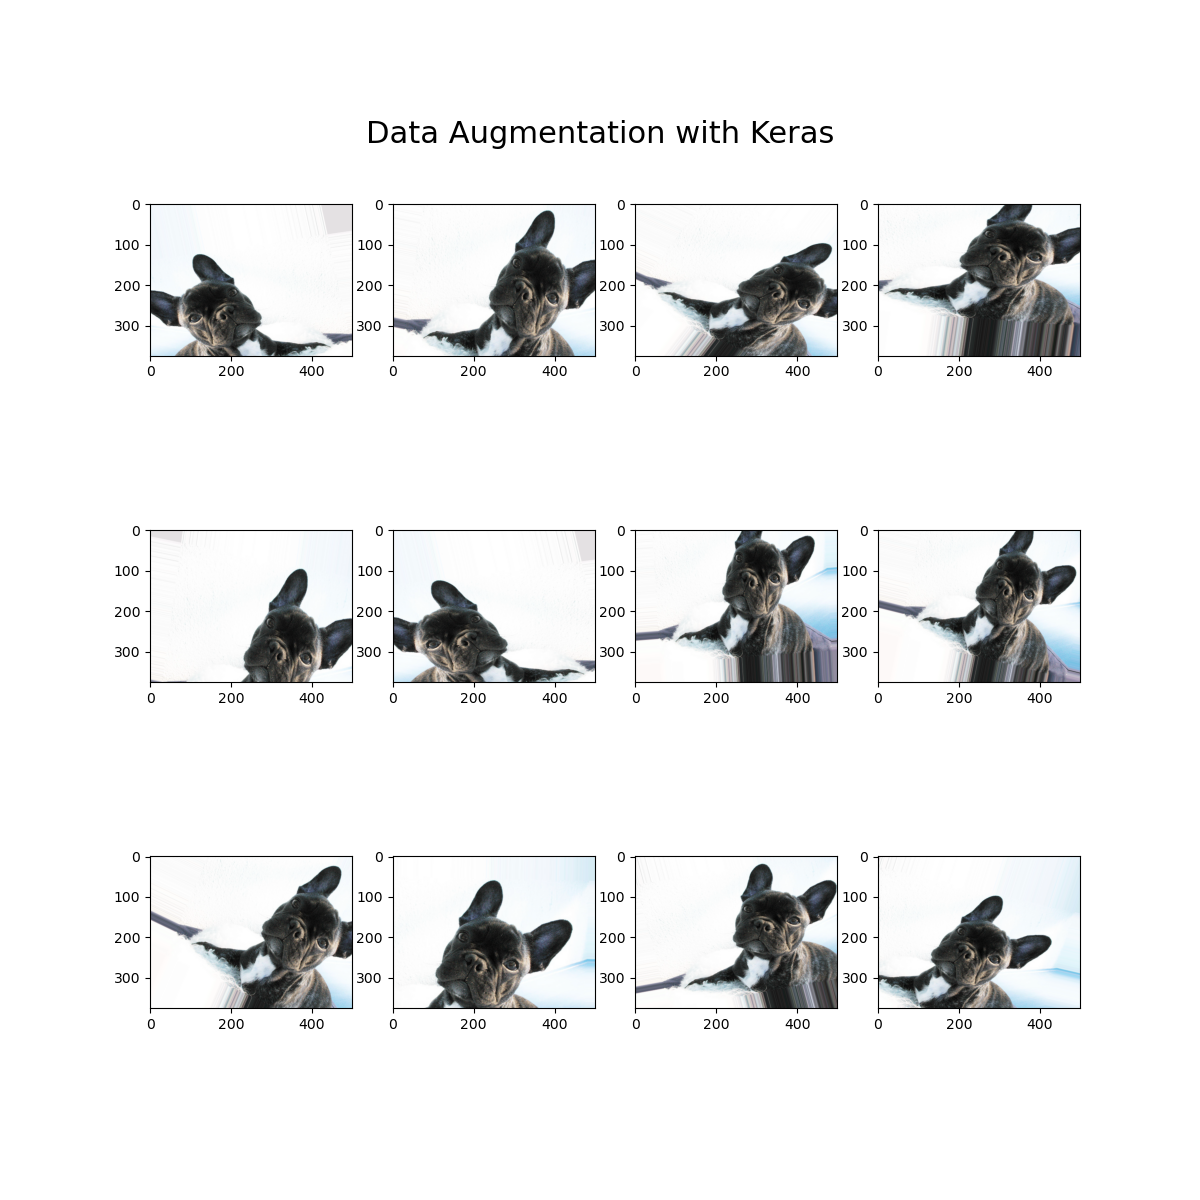

In [21]:
#Initilize Data Generator Keras
augmented_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Convert test img to array
x = image.img_to_array(img_test)
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(12,12))
for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 12 == 0:
        break

plt.suptitle("Data Augmentation with Keras",
             color="black", 
             fontsize=22, y=.90)
plt.show()

## <span style="color:#343434" id="section_1_3">1.3. Fonction de traitement par lot pour le preprocessing.</span>

In [22]:
def preprocessing_cnn(directories, img_width, img_height):
    """Preprocessing of images in order to integrate them 
    into a convolutional neural network. Equalization, 
    Denoising and transformation of the image into Array. 
    Simultaneous creation of labels (y). 

    Parameters
    ---------------------------------------------------
    directoriesList : list
        List of files to be processed.
    img_width : integer
        width of the image to be reached for resizing
    img_height : integer
        height of the image to be reached for resizing
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    for index, breed in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+breed):
            # Read image
            img = cv.imread(images_dir+"/"+breed+"/"+image_name)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            # Resize image
            dim = (img_width, img_height)
            img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
            # Equalization
            img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
            img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
            # Apply non-local means filter on test img
            dst_img = cv.fastNlMeansDenoisingColored(
                src=img_equ,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)
            
            # Convert modified img to array (https://www.tensorflow.org/api_docs/python/tf/keras/utils/img_to_array)
            img_array = image.img_to_array(dst_img)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])
    
    return img_list, labels

In [23]:
list_races

['n02085936-Maltese_dog',
 'n02088094-Afghan_hound',
 'n02092002-Scottish_deerhound',
 'n02112018-Pomeranian',
 'n02108915-French_bulldog']

In [ ]:
# Define numbers of breeds to preprocess
num_breeds = len(list_races) 

# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels (race)
X, y = preprocessing_cnn(list_races, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
preprocess_time = timeit.default_timer() - start_time
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print(f"Number of images preprocessed : {len(y)}")
print(f"Shape of images np.array : {X.shape}")
print("Total time : {:.2f}s".format(preprocess_time))

In [ ]:
X[200]

In [ ]:
# Show exemple preprocessed image
fig = plt.figure(figsize=(6,6))
image1 = np.asanyarray(image.array_to_img(X[1000]))
imshow(image1)
plt.show()

# <span style="color:#343434" id="section_2">2. Réseau CNN</span>

A présents, nos images test ont été pré-traitées grâce notamment à l'égalisation, le débruitage et le redimensionnement. <br/>
Nous avons créé des listes de tableaux Numpy regroupant les images sous format numériques.      <br/>
Pour entrainer notre premier modèle, nous devons dans un premier temps **mélanger les images** car actuellement, toutes les photos d'une même race se suivent.

## <span style="color:#343434" id="section_2_1">2.1. Préparation des données pour le modèle CNN</span>
Nous allons donc mélanger les datas dans X et y pour le premier passage dans le réseau. Ce brassage a pour objectif de réduire la variance et de s'assurer que les modèles ne soient pas sur-entraînés.

In [ ]:
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

In [ ]:
# Show exemple preprocessed image
fig = plt.figure(figsize=(6,6))
image1 = np.asanyarray(image.array_to_img(X[1000]))
imshow(image1)
plt.show()

**Préparation des données pour l'input dans keras :** 
- X -> float
- y -> encodage numérique des donnéees textuelles (races de chien)

In [ ]:
# Change X type 
#X = X.astype(np.float32)
X = X.astype(np.int32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [ ]:
# Verifie encoder created classes
print(encoder.classes_)

In [ ]:
mylist2 = set(y)
mylist2 = list(mylist2)
print(mylist2)

**Training & testing sets**

In [ ]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                   stratify = y
                                                   )

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print(f"Train set size = {x_train.shape[0]}")
print(f"Test set size = {x_test.shape[0]}")

**Augmentation**<br/>
Pour entrainer le modèle sur plus de données nous allons "augmenter" le dataset

In [ ]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training')

## <span style="color:#343434" id="section_2_2">2.2. Modèle complet</span>

Nous allons ici initialiser un premier modèle de réseau de neurones à convolution en imbriquant plusieurs couches :
- **Couches de convolution** : Son but est de repérer la présence d'un ensemble de features dans les images reçues en entrée. Pour cela, on réalise un filtrage par convolution.
- **Couches de Pooling** : L'opération de pooling consiste à réduire la taille des images, tout en préservant leurs caractéristiques importantes.
- **Couches de correction ReLU** : La couche de correction ReLU remplace toutes les valeurs négatives reçues en entrées par des zéros. Elle joue le rôle de fonction d'activation.
- **Couches Fully connected** : Ce type de couche reçoit un vecteur en entrée et produit un nouveau vecteur en sortie. Pour cela, elle applique une combinaison linéaire puis éventuellement une fonction d'activation aux valeurs reçues en entrée.
- **DropOut** : La méthode du dropout consiste à « désactiver » des sorties de neurones aléatoirement pour éviter le sur-entraînement.

Pour notre modèle, nous allons tester une architecture simple, pas trop profonde qui nous servira de baseline pour les procheins modèles. Nous allons donc implémenter uniquement 3 couches de convolution.

Nous allons également définir des **métriques plus précises que Accuracy** pour l'évaluation de notre modèle, comme par exemple le ***Score F1*** qui combine *precision* et *recall* :

**Definition des métriques :**

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
height = X.shape[1]
width = X.shape[2]
num_classes = 5

# Define the model
model = Sequential()

# Input layer and first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 3)))  # height and width should be set based on your data
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# First fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Optional: Dropout for regularization

# Second fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Optional: Dropout for regularization

# Third fully connected layer
model.add(Dense(32, activation='relu'))

# Output layer with softmax activation for classification
model.add(Dense(num_classes, activation='softmax'))  # num_classes should be set based on the number of classes in your problem

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
              metrics=['accuracy'])

# Print the model summary
model.summary()

In [ ]:
# Compile the CNN Model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_m])

**Entrainement du modèle**

In [ ]:
fit = train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training')
validation = train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation')

In [ ]:
fit

In [ ]:
validation

In [ ]:
steps_per_epoch=round(len(x_train) / 32,0)
steps_per_epoch = int(steps_per_epoch)
steps_per_epoch

In [ ]:
history = model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=int(len(x_train) / 32),
    epochs=20,
    verbose=2)